# Grid.gg Esports Match Prediction Pipeline
This notebook implements a machine learning pipeline for predicting esports match outcomes using the Grid.gg API data. The pipeline includes data cleaning, data preprocessing, feature engineering, model training, and evaluation components.

## Pipeline Structure
The pipeline is organized into the following main sections:
1. Data Collection and Cleaning
    - Reading in combined_player_stats_20241117_1343.csv
    - Handling missing values and outliers

2. Feature Engineering

3. Model Development and Evaluation
Three models will be developed and compared:

 - Neural Network: Designed for complex pattern recognition in player performance
 - XGBoost: Proven effectiveness in similar prediction tasks historically with our data and within Shaynes models
 - [Additional Model TBD]: To be selected based on feature characteristics and data structure

4. Model Optimization Possibilities 
    - Hyperparameter tuning
    - Feature importance analysis
    - Performance validation
    - Cross-validation strategies

In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_preprocessing import *
from src.feature_analysis import *
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pickle

## Data Cleaning and Preprocessing

### Data Loading and Initial Assessment
- Loading data from 'combined_player_stats_20241117_1343.csv'
- Initial examination of data structure and completeness
- Documentation of current data shape and basic statistics

### Data Quality Issues to Address

1. Known Invalid Records
    - Identification and removal of ~55 batches of players with all zero statistics
    - Documentation of removed records for future data collection improvement

2. Partial Zero Statistics
    - Analysis of players with some zero statistics but otherwise valid data
    - Determination of valid zero values vs. missing/error data
    - Strategy for handling partially complete player records

3. Team Information Linking
    - Assessment of available team information
    - Preparation for linking player statistics with match results
    - Identification of any missing team affiliations

In [2]:
# Set path and read data
file_path = '../grid_collector/data/combined_player_stats_20241117_1343.csv'
df = pd.read_csv(file_path)

In [3]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Dataset Shape: (5452, 7)

First few rows of the dataset:
   player_id                                  general  \
0       3435  {'series_played': 0, 'games_played': 0}   
1       3436  {'series_played': 0, 'games_played': 0}   
2       3437  {'series_played': 0, 'games_played': 0}   
3       3438  {'series_played': 0, 'games_played': 0}   
4       3439  {'series_played': 0, 'games_played': 0}   

                                              combat  \
0  {'kills': {'total': 0, 'average': 0.0, 'best':...   
1  {'kills': {'total': 0, 'average': 0.0, 'best':...   
2  {'kills': {'total': 0, 'average': 0.0, 'best':...   
3  {'kills': {'total': 0, 'average': 0.0, 'best':...   
4  {'kills': {'total': 0, 'average': 0.0, 'best':...   

                                         performance  \
0  {'wins': {'count': 0, 'percentage': 0, 'curren...   
1  {'wins': {'count': 0, 'percentage': 0, 'curren...   
2  {'wins': {'count': 0, 'percentage': 0, 'curren...   
3  {'wins': {'count': 0, 'percentage': 

In [4]:
# Flatten nested structures (updated with new extraction logic)
# The function has been updated to ensure data that was previously lost is now extracted properly.
flat_df = extract_nested_stats(df)
print("\nFlattened data shape:", flat_df.shape)
print("\nFlattened data columns:")
print(flat_df.columns.tolist())


Flattened data shape: (5452, 32)

Flattened data columns:
['player_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'wins_count', 'win_percentage', 'current_streak', 'avg_net_worth', 'max_net_worth', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round', 'experience_total', 'experience_avg', 'experience_max']


In [5]:
# Remove zero-stat players
# Define columns to check for zeros
stat_columns = [
    'series_played',
    'games_played',
    'total_kills',
    'avg_kills',
    'best_kills',
    'total_deaths',
    'avg_deaths',
    'first_kills_total',
    'first_kills_percentage',
    'damage_total',
    'damage_avg',
    'damage_max',
    'wins_count',
    'win_percentage',
    'current_streak',
    'avg_net_worth',
    'max_net_worth',
    # Commented out stats are from segemnt / progression stats 
    # Players may have one or the other resulting in large amounts of zeros.
    #'total_rounds',
    #'total_segment_kills',
    #'total_segment_deaths',
    #'avg_win_rate',
    #'defuse_with_kit_total',
    #'defuse_without_kit_total',
    #'defuse_bomb_total',
    #'explode_bomb_total',
    #'plant_bomb_total',
    #'avg_kills_per_round',
    #'avg_deaths_per_round',
    #'experience_total',
    #'experience_avg',
    #'experience_max'
]  # Note: Excluded player_id as it's an identifier, not a stat 

# Clean the data
cleaned_df = remove_zero_stat_players(flat_df, stat_columns)

# Print stats about the cleaning
print(f"Original shape: {flat_df.shape}")
print(f"Cleaned shape: {cleaned_df.shape}")
print(f"Removed {flat_df.shape[0] - cleaned_df.shape[0]} rows")

# Let's see the distribution of values in cleaned data
print("\nSummary statistics of cleaned data:")
print(cleaned_df[stat_columns].describe())

# Check if we still have any zeros in individual columns
zero_counts = {col: (cleaned_df[col] == 0).sum() for col in stat_columns}
print("\nRemaining zero values in each column:")
for col, count in zero_counts.items():
    print(f"{col}: {count} zeros")


Original shape: (5452, 32)
Cleaned shape: (1768, 32)
Removed 3684 rows

Summary statistics of cleaned data:
       series_played  games_played  total_kills    avg_kills   best_kills  \
count    1768.000000   1768.000000  1768.000000  1768.000000  1768.000000   
mean        9.728507     22.657805   312.673643    27.626575    40.990385   
std        17.301542     41.640428   649.261385    11.880559    19.033715   
min         1.000000      1.000000     0.000000     0.000000     0.000000   
25%         2.000000      5.000000    46.750000    19.611538    27.000000   
50%         5.000000     10.000000   120.000000    30.870833    43.500000   
75%        10.000000     23.000000   307.500000    36.000000    55.000000   
max       168.000000    403.000000  6682.000000    60.666667    89.000000   

       total_deaths   avg_deaths  first_kills_total  first_kills_percentage  \
count   1768.000000  1768.000000        1768.000000             1768.000000   
mean     315.968326    28.927882        

In [6]:
# Further handling of missing values
# We previously identified that columns 'wins_count', 'win_percentage', 'current_streak', 'avg_net_worth', 'max_net_worth' contained all zeros.
# The rows with these values being all zero match exactly the rows remaining after removing zero-stat players.
# This indicates that these columns are not providing any meaningful differentiation for our remaining dataset.
# Thus, we will drop these columns as they do not contribute any additional information.

# Remove the problematic columns that are all zeros
columns_to_drop = [
    'wins_count',
    'win_percentage', 
    'current_streak',
    'avg_net_worth',
    'max_net_worth'
]

# Drop columns and create final DataFrame
final_df = cleaned_df.drop(columns=columns_to_drop)

# Display results
print(f"Original shape: {flat_df.shape}")
print(f"Cleaned shape after zero-stat removal: {cleaned_df.shape}")
print(f"Final shape after dropping columns: {final_df.shape}")
print(f"\nRemaining columns:")
print(final_df.columns.tolist())
print("\nSummary statistics of remaining columns:")
print(final_df.describe())

Original shape: (5452, 32)
Cleaned shape after zero-stat removal: (1768, 32)
Final shape after dropping columns: (1768, 27)

Remaining columns:
['player_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round', 'experience_total', 'experience_avg', 'experience_max']

Summary statistics of remaining columns:
           player_id  series_played  games_played  total_kills    avg_kills  \
count    1768.000000    1768.000000   1768.000000  1768.000000  1768.000000   
mean   110817.961538       9.728507     22.657805   312.673643    27.626575   
std     14015.940317      17.301542     41.640428   649.261385    11.

In [8]:
# Additional step: Verify if there are still columns that were lost or incorrectly handled during processing
# Ensure that all the segment and progression-related columns are still present in the final DataFrame
expected_columns = [
    'player_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths',
    'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max',
    'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total',
    'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total',
    'avg_kills_per_round', 'avg_deaths_per_round', 'experience_total', 'experience_avg', 'experience_max'
]

# Check if any expected columns are missing
missing_columns = [col for col in expected_columns if col not in final_df.columns]
if missing_columns:
    print("\nWarning: The following expected columns are missing from the final DataFrame:")
    print(missing_columns)
else:
    print("\nAll expected columns are present in the final DataFrame.")

# Save the cleaned and processed DataFrame to a CSV file
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
save_path = f'../grid_collector/data/cleaned_player_stats_{timestamp}.csv'
final_df.to_csv(save_path, index=False)
print(f"\nCleaned DataFrame saved to {save_path}")


All expected columns are present in the final DataFrame.

Cleaned DataFrame saved to ../grid_collector/data/cleaned_player_stats_20241117_1728.csv


## Integrating Filtered Player Data with Cleaned Player Stats

In this step, we **integrated the filtered player data** that contained enriched information, such as **title IDs** and other relevant attributes, into our existing **cleaned player statistics** dataset. This integration will allow us to have a complete view of each player's profile, enhancing our ability to analyze and model player performance based on both statistical and contextual data.

#### Process Outline

1. **Load Filtered Player Data**: We start by loading the previously saved filtered player data (`filtered_players_<timestamp>.csv`). This data contains enriched details, such as player nicknames, team information, and **title IDs**, which helps us better contextualize the players.

2. **Drop Unnecessary Columns**: To simplify the dataset, we drop unnecessary columns from the player data that are not needed for the next steps in our analysis. For this integration, we're focused on retaining the core attributes required for merging and modeling.

3. **Join Data on Player ID**: The next step involves joining the filtered player data with the cleaned player statistics on the `player_id`. This merge allows us to enhance our player statistics by adding enriched contextual information, which will support more nuanced feature analysis and provide a comprehensive dataset for modeling.

4. **Split by Title ID**: After merging, we **split the dataset by `title_id`** to create separate DataFrames for each game. This allows us to handle each title's unique data separately, facilitating more specialized analysis.

5. **Manually Rename DataFrames**: As there are only two titles in the dataset, we manually rename the resulting DataFrames for easier reference (`cs2_df` for Counter-Strike 2 and `dota_df` for Dota 2).

6. **Pickled the two DataFrames**: Pickled the data frames to be able to continue using them on this notebook without having to re-run this part of it and overwrite our saved files. 

In [2]:
# Set path and read data
f_file_path = '../grid_collector/data/filtered_players_data_20241118_0001.csv'
id_df = pd.read_csv(f_file_path)

# Set path for title data
t_file_path = '../grid_collector/data/titles.csv'
titles_df = pd.read_csv(t_file_path)

In [3]:
print("\nFirst few rows of the dataset:")
print(id_df.head())
print("\nColumn names:")
print(id_df.columns.tolist())


First few rows of the dataset:
      id    nickname             title  team_id   team_name  private
0  19537      jambo.  Counter Strike 2    52356  Passion UA    False
1  19538  marat2k 風速  Counter Strike 2    52133         L&G    False
2  19539    s-chilla  Counter Strike 2    52356  Passion UA    False
3  19540    jackasmo  Counter Strike 2    52356  Passion UA    False
4  19541    zeRRoFIX  Counter Strike 2    52356  Passion UA    False

Column names:
['id', 'nickname', 'title', 'team_id', 'team_name', 'private']


In [4]:
# Create a dictionary mapping from title name to title_id from titles.csv
title_mapping = dict(zip(titles_df['name'], titles_df['id']))

# Map the 'title' column in id_df to 'title_id' using the dictionary
id_df['title_id'] = id_df['title'].map(title_mapping)

# Drop the 'title' column as we now have 'title_id'
id_df.drop(columns=['title'], inplace=True)

# Display the first few rows of id_df to confirm the title replacement
print("\nFirst few rows of id_df with updated title_id:")
print(id_df.head())

# Verify that the 'title_id' column has been added correctly
print("\nColumn names after updating title_id:")
print(id_df.columns.tolist())


First few rows of id_df with updated title_id:
      id    nickname  team_id   team_name  private  title_id
0  19537      jambo.    52356  Passion UA    False        28
1  19538  marat2k 風速    52133         L&G    False        28
2  19539    s-chilla    52356  Passion UA    False        28
3  19540    jackasmo    52356  Passion UA    False        28
4  19541    zeRRoFIX    52356  Passion UA    False        28

Column names after updating title_id:
['id', 'nickname', 'team_id', 'team_name', 'private', 'title_id']


In [5]:
# Remove the private column
id_df = id_df.drop(columns=['private'])

# Display basic information about the dataset
print("\nDataset Shape:", id_df.shape)
print("\nColumn names:")
print(id_df.columns.tolist())


Dataset Shape: (1768, 5)

Column names:
['id', 'nickname', 'team_id', 'team_name', 'title_id']


In [6]:
# Rename id column to player_id to match the other dataset we want to merge with
id_df = id_df.rename(columns={'id': 'player_id'})

# Confirm the column name change and datatype
print("\nColumn names:")
print(id_df.columns.tolist())
print("\nDatatypes:")
print(id_df.dtypes)


Column names:
['player_id', 'nickname', 'team_id', 'team_name', 'title_id']

Datatypes:
player_id     int64
nickname     object
team_id       int64
team_name    object
title_id      int64
dtype: object


In [7]:
# Bring in cleaned player stats data
stat_file_path = '../grid_collector/data/cleaned_player_stats_20241117_1728.csv'
stats_df = pd.read_csv(stat_file_path)

# View the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(stats_df.head())
print("\nColumn names:")
print(stats_df.columns.tolist())
print("\nDatatypes:")
print(stats_df.dtypes)


First few rows of the dataset:
   player_id  series_played  games_played  total_kills  avg_kills  best_kills  \
0     116746              3             7           93  31.000000          44   
1     116748              3             7           91  30.333333          46   
2     116750              2             4           49  24.500000          39   
3     116752              2             4           74  37.000000          59   
4     116753              2             4            0   0.000000           0   

   total_deaths  avg_deaths  first_kills_total  first_kills_percentage  ...  \
0            80   26.666667                  3                   100.0  ...   
1            90   30.000000                  3                   100.0  ...   
2            60   30.000000                  1                    50.0  ...   
3            55   27.500000                  2                   100.0  ...   
4             4    2.000000                  2                   100.0  ...   

   def

In [8]:
# Set the player_id column as the index for both DataFrames
id_df.set_index('player_id', inplace=True)
stats_df.set_index('player_id', inplace=True)

# Merge the two DataFrames on the player_id index
full_df = id_df.join(stats_df, how='inner')

# Display basic information about the merged dataset
print("\nMerged Dataset Shape:", full_df.shape)
print("\nColumn names:")
print(full_df.columns.tolist())
print("\nDatatypes:")
print(full_df.dtypes)




Merged Dataset Shape: (1768, 30)

Column names:
['nickname', 'team_id', 'team_name', 'title_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round', 'experience_total', 'experience_avg', 'experience_max']

Datatypes:
nickname                     object
team_id                       int64
team_name                    object
title_id                      int64
series_played                 int64
games_played                  int64
total_kills                   int64
avg_kills                   float64
best_kills                    int64
total_deaths                  int64
avg_deaths                  float64


In [9]:
# Split full_df into multiple DataFrames based on the title_id
title_dataframes = split_dataframe_by_title_id(full_df)

# Display the amount of titles in the dataset
print("\nNumber of titles in the dataset:", len(title_dataframes))
# Display the first few rows of each title DataFrame
for title_id, title_df in title_dataframes.items():
    print(f"\nTitle ID: {title_id}")
    print(title_df.head())
    print("Amount of players:", title_df.shape[0])

# Rename each of the DataFrames to match the title name
cs2_df = title_dataframes.get(28, pd.DataFrame())
dota_df = title_dataframes.get(2, pd.DataFrame())

# Display the first few rows of the DataFrames
print("\nCounter-Strike: Global Offensive DataFrame:")
print(cs2_df.head())
print("\nDota 2 DataFrame:")
print(dota_df.head())


Number of titles in the dataset: 2

Title ID: 28
     nickname  team_id   team_name  title_id  series_played  games_played  \
0      jambo.    52356  Passion UA        28             33            79   
1  marat2k 風速    52133         L&G        28             42           100   
2    s-chilla    52356  Passion UA        28             33            79   
3    jackasmo    52356  Passion UA        28             33            79   
4    zeRRoFIX    52356  Passion UA        28             33            79   

   total_kills  avg_kills  best_kills  total_deaths  ...  \
0         1381  41.848485          60          1069  ...   
1         1427  33.976190          61          1404  ...   
2         1024  31.030303          59          1148  ...   
3         1251  37.909091          57          1151  ...   
4         1178  35.696970          67          1116  ...   

   defuse_with_kit_total  defuse_without_kit_total  defuse_bomb_total  \
0                   23.0                      18.0   

In [10]:
# Remove the title_id column from each DataFrame
cs2_df = cs2_df.drop(columns=['title_id'])
dota_df = dota_df.drop(columns=['title_id'])

# Display columns with all missing values as they were for the other title and will need to be removed
print("\nColumns with all missing values in Counter-Strike: Global Offensive DataFrame:")
print(cs2_df.columns[cs2_df.isnull().all()].tolist())
print("\nColumns with all missing values in Dota 2 DataFrame:")
print(dota_df.columns[dota_df.isnull().all()].tolist())


Columns with all missing values in Counter-Strike: Global Offensive DataFrame:
['experience_total', 'experience_avg', 'experience_max']

Columns with all missing values in Dota 2 DataFrame:
['total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round']


In [11]:
# Remove columns with all missing values
cs2_df = cs2_df.dropna(axis=1, how='all')
dota_df = dota_df.dropna(axis=1, how='all')

# Display remaining columns
print("\nRemaining columns in Counter-Strike: Global Offensive DataFrame:")
print(cs2_df.columns.tolist())
print("\nRemaining columns in Dota 2 DataFrame:")
print(dota_df.columns.tolist())


Remaining columns in Counter-Strike: Global Offensive DataFrame:
['nickname', 'team_id', 'team_name', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'defuse_bomb_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round']

Remaining columns in Dota 2 DataFrame:
['nickname', 'team_id', 'team_name', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'experience_total', 'experience_avg', 'experience_max']


In [12]:
# Check for columns with all 0 values
zero_columns_cs2 = cs2_df.columns[(cs2_df == 0).all()].tolist()
zero_columns_dota = dota_df.columns[(dota_df == 0).all()].tolist()

# Display columns with all 0 values
print("\nColumns with all 0 values in Counter-Strike: Global Offensive DataFrame:")
print(zero_columns_cs2)
print("\nColumns with all 0 values in Dota 2 DataFrame:")
print(zero_columns_dota)


Columns with all 0 values in Counter-Strike: Global Offensive DataFrame:
['defuse_bomb_total']

Columns with all 0 values in Dota 2 DataFrame:
['damage_total', 'damage_avg', 'damage_max']


In [13]:
# Remove columns with all 0 values
cs2_df = cs2_df.drop(columns=zero_columns_cs2)
dota_df = dota_df.drop(columns=zero_columns_dota)

# Display remaining columns
print("\nRemaining columns in Counter-Strike: Global Offensive DataFrame:")
print(cs2_df.columns.tolist())
print("\nRemaining columns in Dota 2 DataFrame:")
print(dota_df.columns.tolist())


Remaining columns in Counter-Strike: Global Offensive DataFrame:
['nickname', 'team_id', 'team_name', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round']

Remaining columns in Dota 2 DataFrame:
['nickname', 'team_id', 'team_name', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'experience_total', 'experience_avg', 'experience_max']


In [14]:
# Save the Counter-Strike DataFrame
with open('../processed_data/cs2_df.pkl', 'wb') as cs2_file:
    pickle.dump(cs2_df, cs2_file)

# Save the Dota 2 DataFrame
with open('../processed_data/dota_df.pkl', 'wb') as dota_file:
    pickle.dump(dota_df, dota_file)

print("DataFrames have been saved in the 'data/processed' folder.")


DataFrames have been saved in the 'data/processed' folder.


## Feature Analysis

Now that we've successfully merged and enriched our player statistics data, it's time to **begin feature analysis**. In this step, we will:

- **Identify Key Features**: Evaluate the different attributes within our dataset to determine which features are most relevant for predicting player performance.
- **Prepare Data for Modeling**: Clean and transform features as needed, ensuring they are properly formatted and ready for model input.
- **Handle Game-Specific Differences**: Since we've split the dataset by `title_id`, we'll explore game-specific features and adapt our analysis to account for differences between games.

The ultimate goal is to understand which attributes drive player success and how they vary across different titles, setting the foundation for predictive modeling.

In [2]:
# Load the pickled DataFrames
with open('../processed_data/cs2_df.pkl', 'rb') as cs2_file:
    cs2_df = pickle.load(cs2_file)
with open('../processed_data/dota_df.pkl', 'rb') as dota_file:
    dota_df = pickle.load(dota_file)

In [3]:
# Confirm the DataFrames have been loaded correctly and display the first few rows
print("\nCounter-Strike: Global Offensive DataFrame:")
print(cs2_df.head())
print("\nDota 2 DataFrame:")
print(dota_df.head())

# Display column names for each DataFrame
print("\nCounter-Strike: Global Offensive DataFrame columns:")
print(cs2_df.columns.tolist())
print("\nDota 2 DataFrame columns:")
print(dota_df.columns.tolist())


Counter-Strike: Global Offensive DataFrame:
     nickname  team_id   team_name  series_played  games_played  total_kills  \
0      jambo.    52356  Passion UA             33            79         1381   
1  marat2k 風速    52133         L&G             42           100         1427   
2    s-chilla    52356  Passion UA             33            79         1024   
3    jackasmo    52356  Passion UA             33            79         1251   
4    zeRRoFIX    52356  Passion UA             33            79         1178   

   avg_kills  best_kills  total_deaths  avg_deaths  ...  total_rounds  \
0  41.848485          60          1069   32.393939  ...        1720.0   
1  33.976190          61          1404   33.428571  ...        2097.0   
2  31.030303          59          1148   34.787879  ...        1720.0   
3  37.909091          57          1151   34.878788  ...        1720.0   
4  35.696970          67          1116   33.818182  ...        1720.0   

   total_segment_kills  total_segme

In [4]:
# Display numberical columns for each DataFrame
print("CS2 numeric columns:")
print(cs2_df.select_dtypes(include=['float64', 'int64']).columns.tolist())
print("\nDota 2 numeric columns:")
print(dota_df.select_dtypes(include=['float64', 'int64']).columns.tolist())

CS2 numeric columns:
['team_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'damage_total', 'damage_avg', 'damage_max', 'total_rounds', 'total_segment_kills', 'total_segment_deaths', 'avg_win_rate', 'defuse_with_kit_total', 'defuse_without_kit_total', 'explode_bomb_total', 'plant_bomb_total', 'avg_kills_per_round', 'avg_deaths_per_round']

Dota 2 numeric columns:
['team_id', 'series_played', 'games_played', 'total_kills', 'avg_kills', 'best_kills', 'total_deaths', 'avg_deaths', 'first_kills_total', 'first_kills_percentage', 'experience_total', 'experience_avg', 'experience_max']


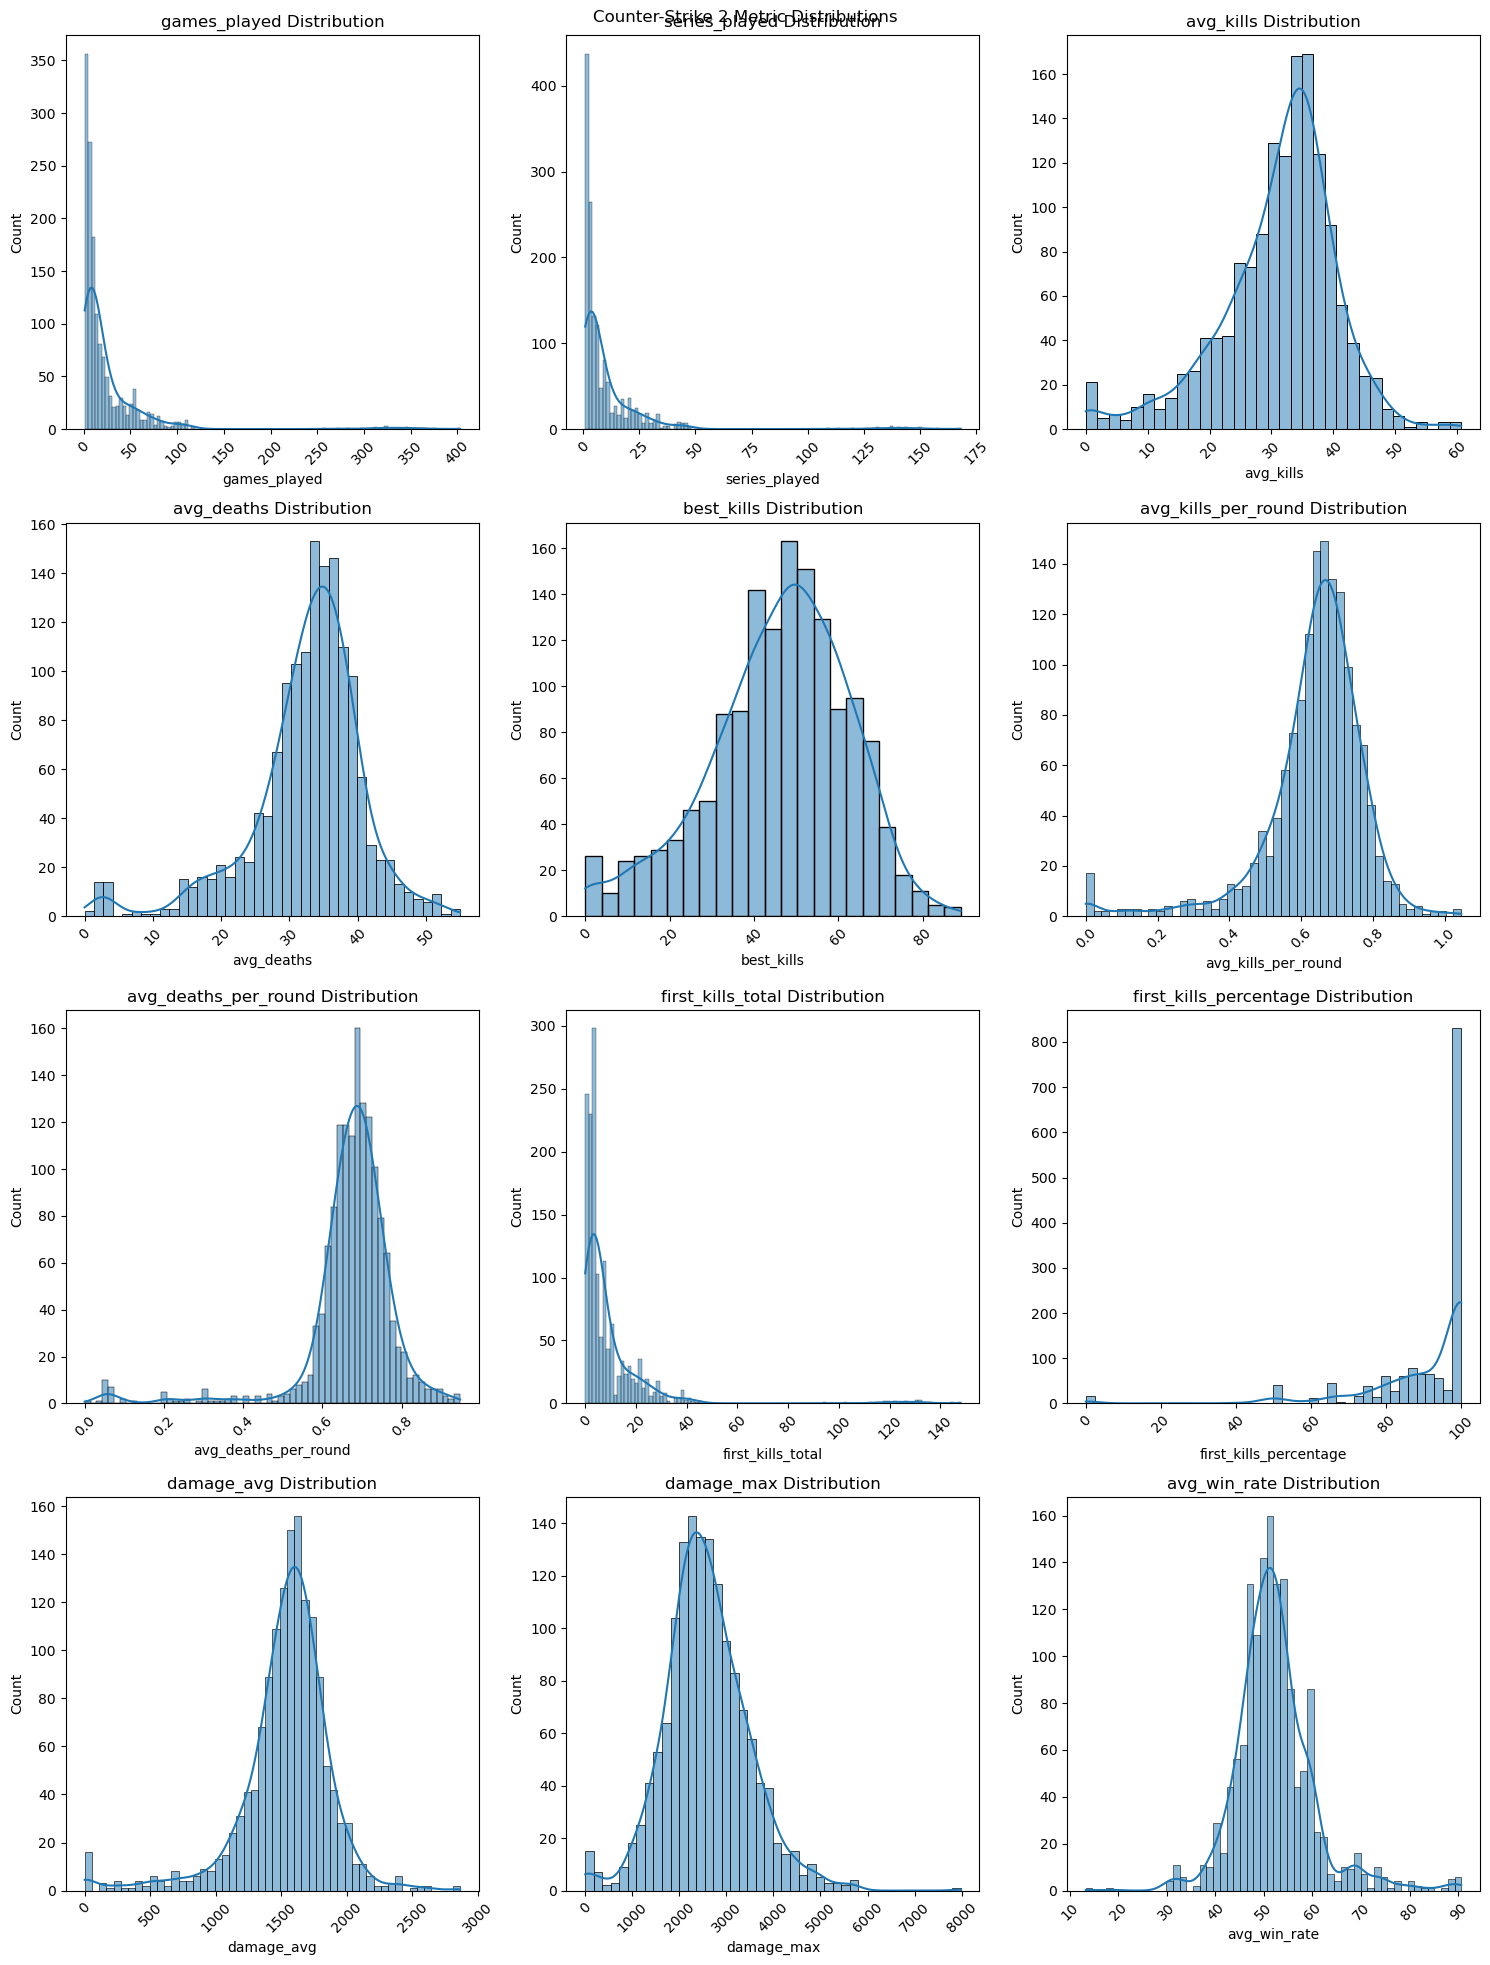

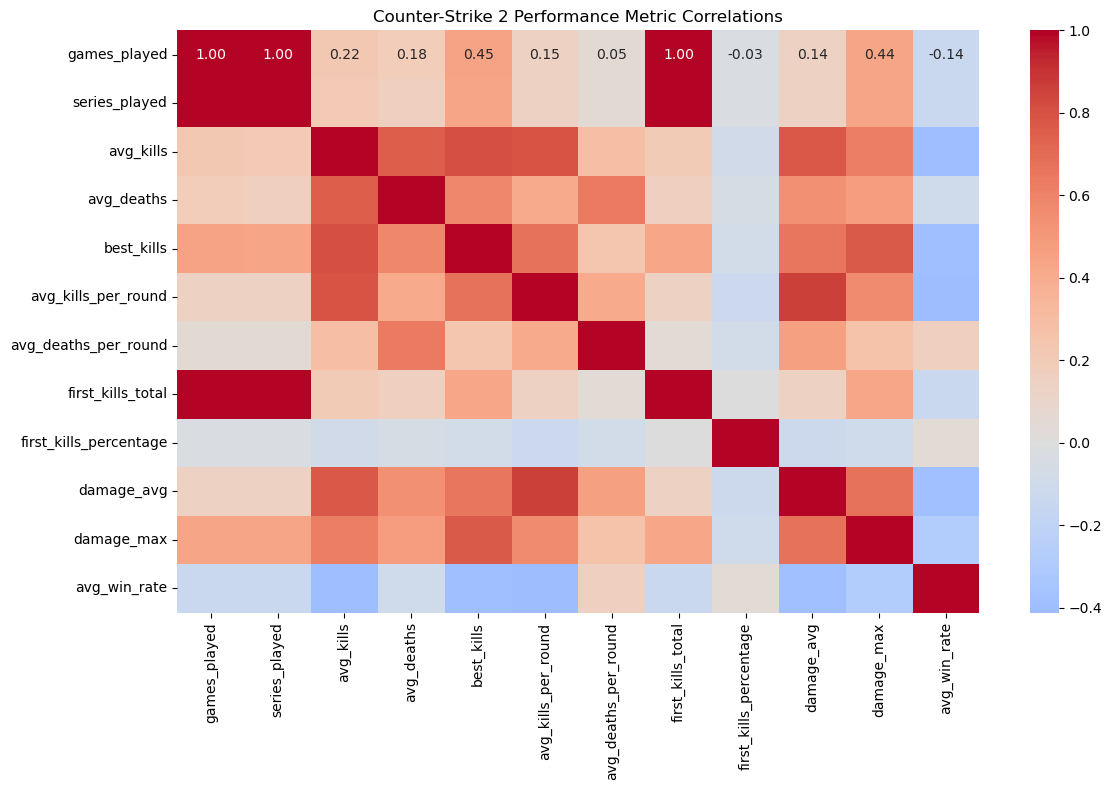


==================== Counter-Strike 2 Analysis ====================

Metrics Analyzed:
['games_played', 'series_played', 'avg_kills', 'avg_deaths', 'best_kills', 'avg_kills_per_round', 'avg_deaths_per_round', 'first_kills_total', 'first_kills_percentage', 'damage_avg', 'damage_max', 'avg_win_rate']

Basic Statistics:
       games_played  series_played    avg_kills   avg_deaths   best_kills  \
count   1469.000000    1469.000000  1469.000000  1469.000000  1469.000000   
mean      24.698434      10.478557    31.176998    32.623357    45.882233   
std       45.025995      18.721619     9.400560     8.188265    16.586053   
min        1.000000       1.000000     0.000000     0.000000     0.000000   
25%        5.000000       2.000000    26.444444    29.500000    36.000000   
50%       11.000000       5.000000    33.000000    33.800000    48.000000   
75%       26.000000      11.000000    36.941176    37.428571    58.000000   
max      403.000000     168.000000    60.666667    55.000000    

In [5]:
# Cs2 report
cs2_report = generate_game_report(cs2_df, 'cs2')
print_game_report(cs2_report)

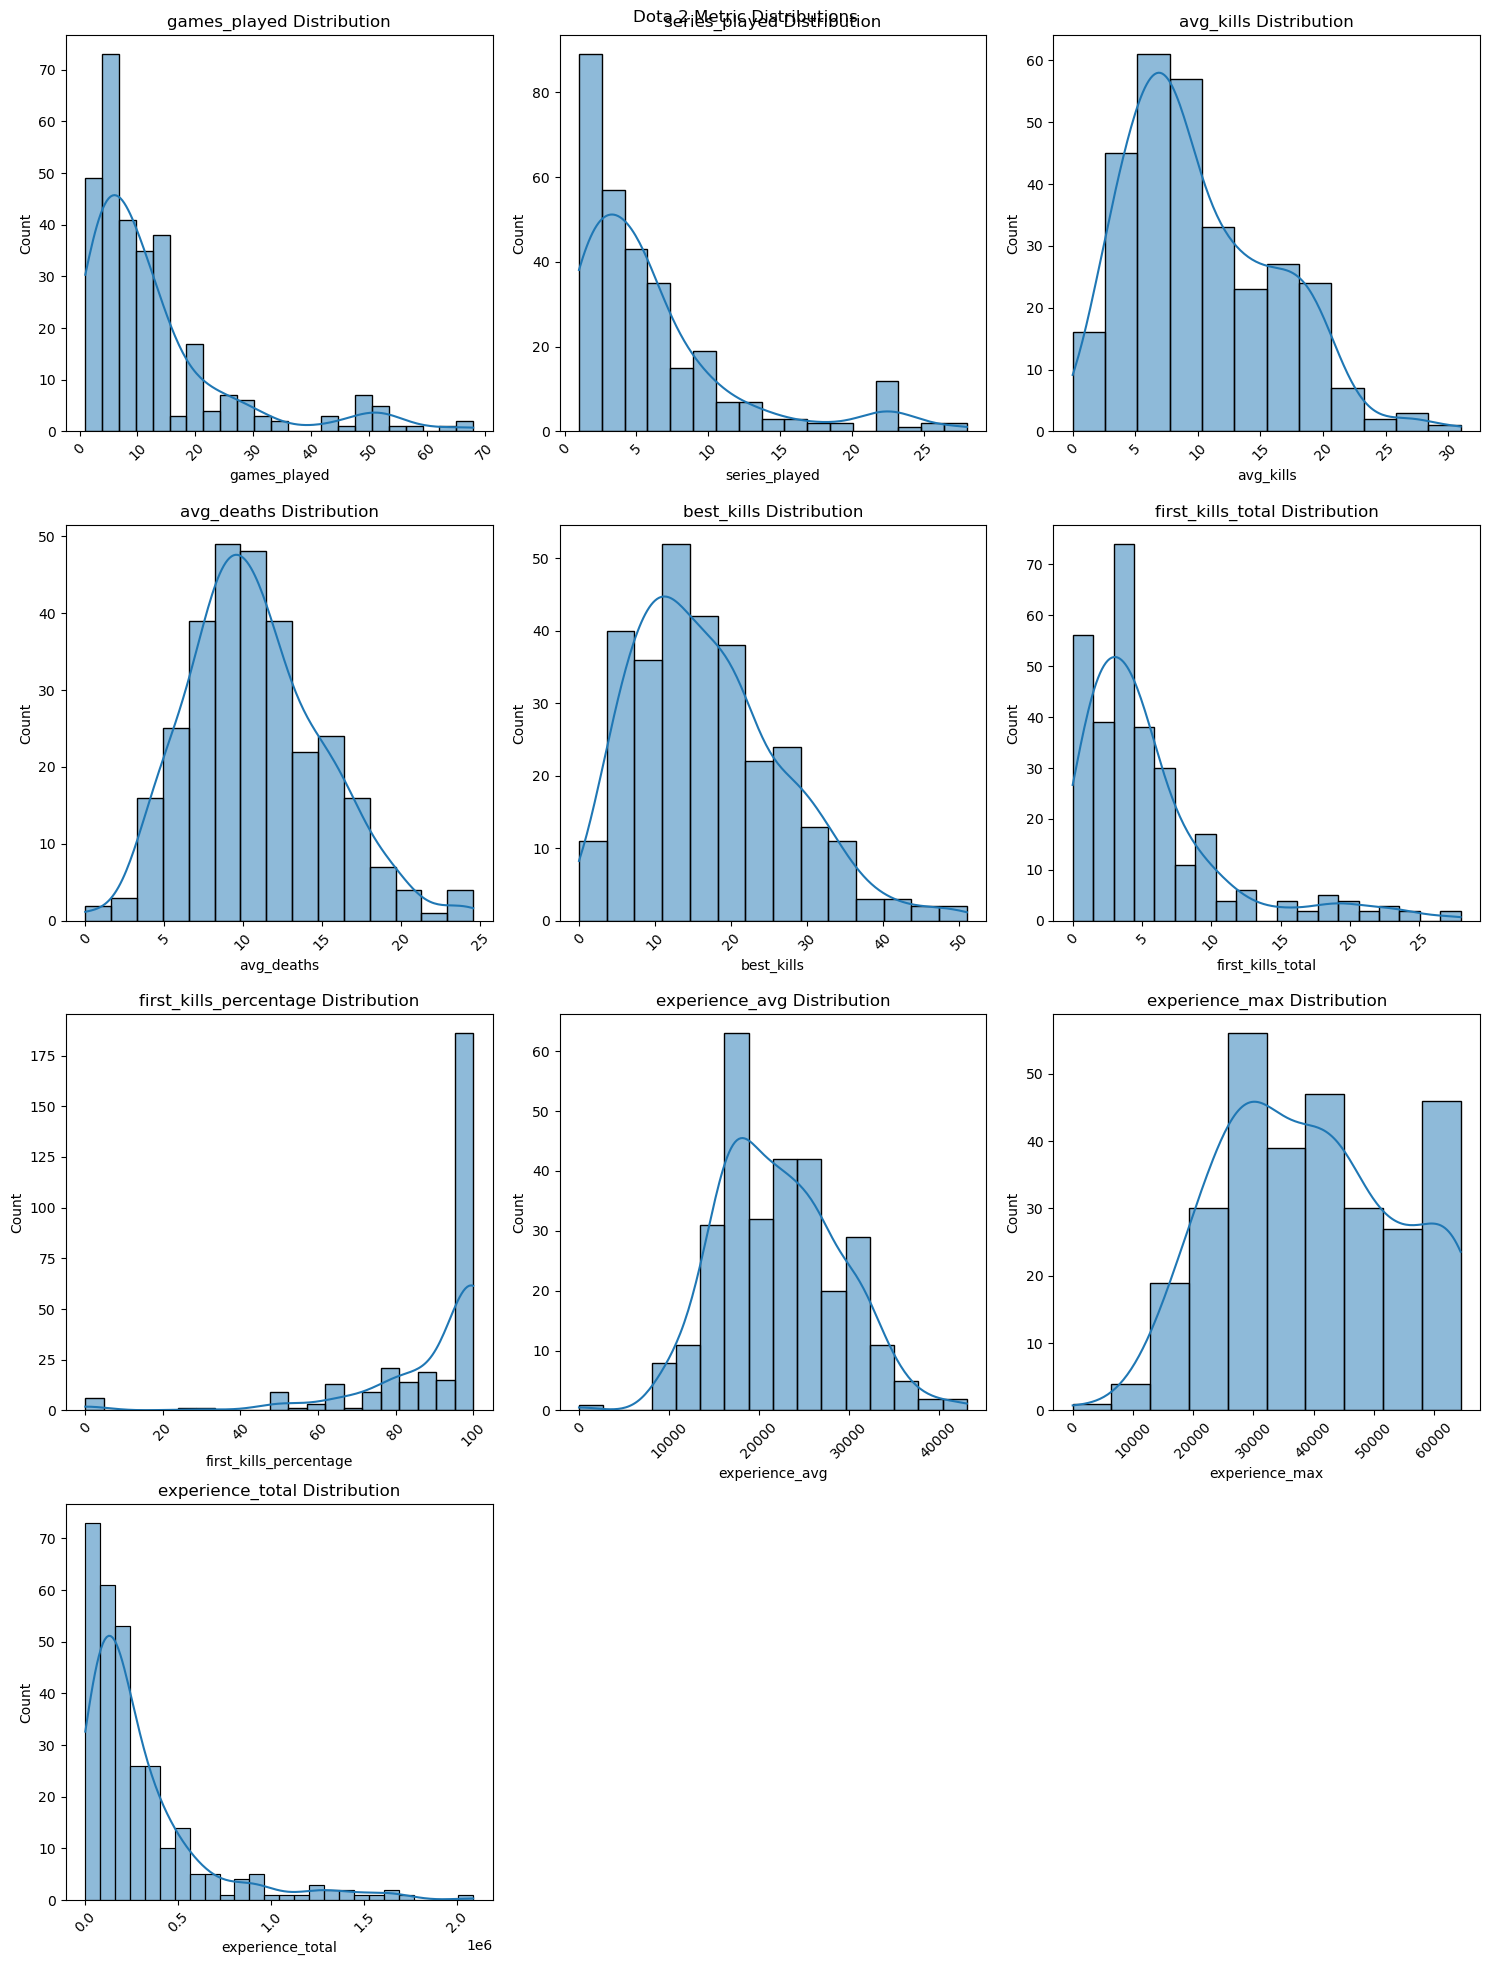

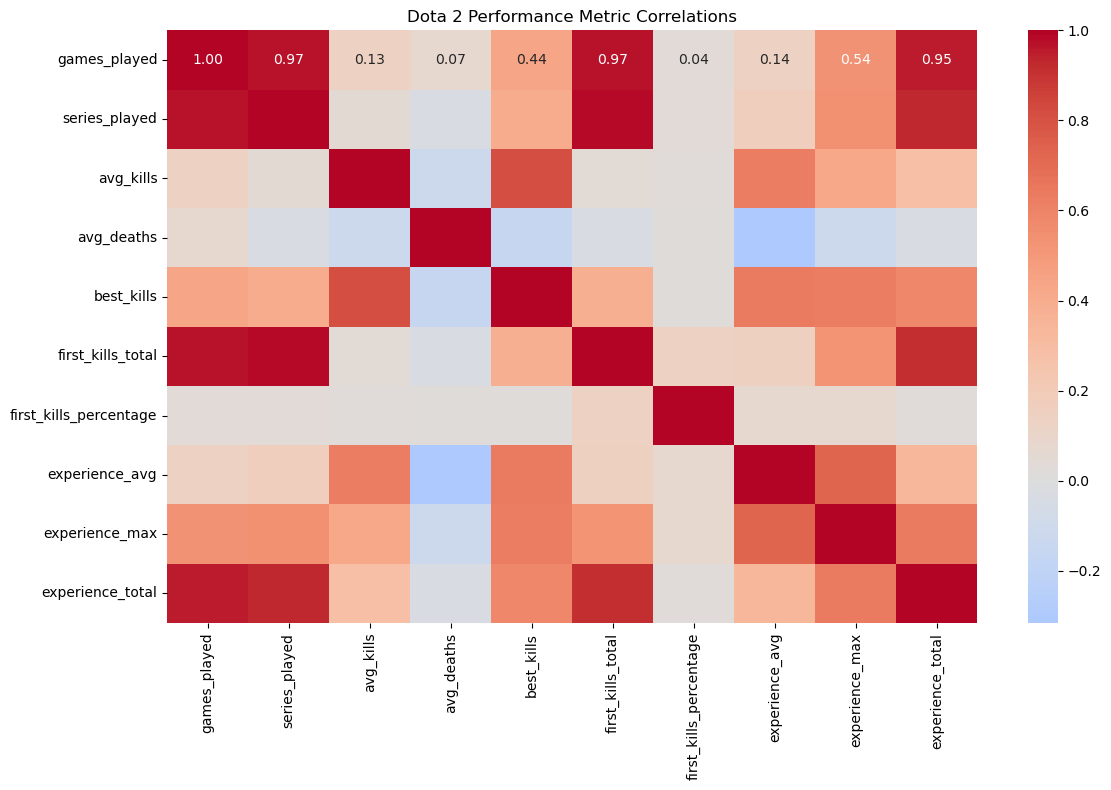


==================== Dota 2 Analysis ====================

Metrics Analyzed:
['games_played', 'series_played', 'avg_kills', 'avg_deaths', 'best_kills', 'first_kills_total', 'first_kills_percentage', 'experience_avg', 'experience_max', 'experience_total']

Basic Statistics:
       games_played  series_played   avg_kills  avg_deaths  best_kills  \
count    299.000000     299.000000  299.000000  299.000000  299.000000   
mean      12.632107       6.043478   10.183193   10.771854   16.956522   
std       13.151101       5.652236    5.846280    4.304042    9.770253   
min        1.000000       1.000000    0.000000    0.000000    0.000000   
25%        4.000000       2.000000    5.845238    7.816667   10.000000   
50%        8.000000       5.000000    8.714286   10.227273   16.000000   
75%       14.000000       7.500000   14.500000   13.366667   23.000000   
max       68.000000      28.000000   31.000000   24.571429   51.000000   

       first_kills_total  first_kills_percentage  experien

In [6]:
# Dota report
dota_report = generate_game_report(dota_df, 'dota')
print_game_report(dota_report)

In [8]:
# Import advanced data analysis functions
from src.advanced_analysis import *
# For CS2 data
cs2_analyzer = CS2Analyzer(cs2_df)
cs2_report = generate_game_report(cs2_df, 'cs2')
print_game_report(cs2_report)

# For Dota2 data 
dota_analyzer = Dota2Analyzer(dota_df)
dota_report = generate_game_report(dota_df, 'dota2')
print_game_report(dota_report)


=== CS2 Comprehensive Analysis ===

Player Base: 1469 players

Experience Distribution:
count    1469.000000
mean       24.698434
std        45.025995
min         1.000000
25%         5.000000
50%        11.000000
75%        26.000000
max       403.000000
Name: games_played, dtype: float64

Consistency Metrics:
       kills_consistency  damage_consistency  round_consistency
count        1453.000000         1454.000000        1468.000000
mean            0.718030            0.631180               -inf
std             0.159698            0.146573                NaN
min             0.333333            0.125000               -inf
25%             0.598148            0.521634          -0.187812
50%             0.687500            0.624086          -0.035575
75%             0.817073            0.720610           0.072894
max             1.000000            1.000000           0.823529

Specialization Metrics:
       entry_rating  survival_rating  support_rating
count   1469.000000      1469.00

# CS2 and Dota2 Performance Analysis

## Dataset Overview
### CS2 Dataset
- Sample size: 1,469 players
- Experience range: 1-403 games (median: 11)
- Performance metrics coverage: Kills, deaths, damage, objectives, win rates

### Dota2 Dataset
- Sample size: 299 players
- Experience range: 1-68 games (median: 8)
- Performance metrics coverage: Kills, deaths, experience, first kills

## Key Findings

### CS2 Insights
1. Player Experience Distribution
   - Highly right-skewed distribution
   - Most players have relatively few games (median: 11)
   - Small core of very experienced players (>100 games)

2. Performance Patterns
   - Average kills per round: 0.64
   - Average deaths per round: 0.67
   - Kill/death ratio slightly below 1, suggesting balanced matchmaking
   - High first kill percentage (mean: 90.8%)
   - Damage output normally distributed around 1534 per game

3. Role Distribution
   - Entry fraggers: Mean rating 89.15 (std: 36.13)
   - Support players: Average rating 0.44
   - Objective players: Mean rating 1.57

4. Player Clustering Results
   - Balanced players (steady performance across metrics)
   - Low engagement players (possibly incomplete data)
   - Aggressive players (high kills, low deaths)
   - Support players (high deaths, high win rate)
   - Objective-focused players (low first kills, steady damage)

### Dota2 Insights
1. Player Experience Distribution
   - More condensed experience range
   - Lower average games played (12.6)
   - More uniform distribution of experience levels

2. Performance Patterns
   - Average kills: 10.18 per game
   - Average deaths: 10.77 per game
   - Kill/death ratio close to 1
   - High first kill percentage (89.7%)
   - Experience metrics show wide variation

3. Player Roles
   - Carry performance shows high variance
   - Early game impact more consistently distributed
   - Clear distinction between core and support players

4. Player Clustering Results
   - Sacrificial (high deaths, low exp)
   - Carry (high kills, low deaths, high exp)
   - Balanced (moderate across metrics)
   - Support (low kills, moderate deaths)
   - Ganker (moderate stats, low first kill %)

## Feature Selection for Modeling

### CS2 Selected Features
1. `games_played`
   - Rationale: Experience indicator
   - Preprocessing: Log transformation recommended due to right skew

2. `avg_kills_per_round`
   - Rationale: Core performance metric
   - Preprocessing: Standard scaling

3. `avg_deaths_per_round`
   - Rationale: Survival metric
   - Preprocessing: Standard scaling

4. `first_kills_percentage`
   - Rationale: Entry impact
   - Preprocessing: Already normalized (0-100)

5. `damage_avg`
   - Rationale: Overall impact
   - Preprocessing: Standard scaling

6. `avg_win_rate`
   - Rationale: Performance outcome
   - Preprocessing: Already normalized (0-100)

### Dota2 Selected Features
1. `games_played`
   - Rationale: Experience indicator
   - Preprocessing: Log transformation recommended

2. `avg_kills`
   - Rationale: Core performance metric
   - Preprocessing: Standard scaling

3. `avg_deaths`
   - Rationale: Survival metric
   - Preprocessing: Standard scaling

4. `first_kills_percentage`
   - Rationale: Early game impact
   - Preprocessing: Already normalized (0-100)

5. `experience_avg`
   - Rationale: Resource efficiency
   - Preprocessing: Standard scaling

## Feature Preprocessing Steps
1. Handle Missing Values
   - Check for NaN values
   - Consider game-specific imputation strategies

2. Handle Outliers
   - Use IQR method for extreme value detection
   - Consider game-specific thresholds

3. Feature Scaling
   - Apply log transformation to `games_played`
   - Standard scale non-normalized features
   - Preserve already normalized percentages

4. Feature Engineering Considerations
   - Consider interaction terms between key metrics
   - Evaluate polynomial features for non-linear relationships

## Excluded Features (To Avoid Redundancy)
### CS2
- `series_played` (correlates with games_played)
- `best_kills` (correlates with avg_kills)
- `first_kills_total` (percentage used instead)
- `damage_max` (correlates with damage_avg)

### Dota2
- `series_played` (correlates with games_played)
- `best_kills` (correlates with avg_kills)
- `first_kills_total` (percentage used instead)
- `experience_max/total` (correlate with avg)